# LSTM Hyperparameter Tuning Results Analysis

This notebook provides a comprehensive analysis of all LSTM experiments run using Optuna for Henry Hub natural gas price prediction.

## Contents
1. **Experiment Overview** — Summary statistics for each experiment
2. **Best Model Comparison** — Metrics comparison across experiments
3. **Pruning Analysis** — Pruning rates and efficiency per experiment
4. **Hyperparameter Analysis** — Distributions and impact of parameters
5. **Cross-Experiment Parameter Comparison** — What works best overall
6. **Visualizations** — Charts and graphs for all comparisons

### Experiments Analysed:
- **Price Only** — Univariate model using only historical prices
- **Price + Storage** — Prices with gas storage levels
- **Price + Production** — Prices with US dry gas production
- **Price + USD** — Prices with USD index
- **Price + Weather** — Prices with HDD/CDD weather data
- **Price + Storage + Production + USD + Weather** — All features combined

In [1]:
# === Cell 1: Setup and Imports ===
import os
import json
import ast
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10
sns.set_style("whitegrid")

# Color palette for experiments
EXPERIMENT_COLORS = {
    "Price Only": "#1f77b4",
    "Price + Storage": "#ff7f0e", 
    "Price + Production": "#2ca02c",
    "Price + USD": "#d62728",
    "Price + Weather": "#9467bd",
    "All Features": "#8c564b"
}

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 1. Load All Experiment Data

Define paths to each experiment's trial summary CSV and load the data.

In [2]:
# === Cell 2: Define Experiment Paths and Load Data ===

SAVED_RESULTS_DIR = Path("saved_results")

# Mapping of experiment names to their folder names
EXPERIMENTS = {
    "Price Only": "20260114-035227_PriceOnly_lstm",
    "Price + Storage": "20260114-035229_Price+Storage_lstm",
    "Price + Production": "20260112-134312_Price+Production_lstm",
    "Price + USD": "20260112-193411_Price+USD_lstm",
    "Price + Weather": "20260112-193422_Price+Weather_lstm",
    "All Features": "20260112-222817_Price_Stor_Prod_USD_Weather_lstm"
}

def load_trial_summary(experiment_dir: Path) -> pd.DataFrame:
    """Load trial_summary.csv and parse the params JSON column."""
    csv_path = experiment_dir / "trial_summary.csv"
    if not csv_path.exists():
        print(f"⚠️ Not found: {csv_path}")
        return None
    
    df = pd.read_csv(csv_path)
    
    # Parse params column from JSON string to dict
    if 'params' in df.columns:
        df['params_dict'] = df['params'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
        
        # Extract individual hyperparameters
        df['lookback'] = df['params_dict'].apply(lambda x: x.get('lookback'))
        df['batch_size'] = df['params_dict'].apply(lambda x: x.get('batch_size'))
        df['layers'] = df['params_dict'].apply(lambda x: x.get('layers'))
        df['dropout'] = df['params_dict'].apply(lambda x: x.get('dropout'))
        df['lr'] = df['params_dict'].apply(lambda x: x.get('lr'))
        
        # Extract units (handle different layer configurations)
        df['units'] = df['params_dict'].apply(lambda x: 
            x.get('units1') or x.get('units2_idx') or x.get('units3_idx') or 0
        )
    
    return df

# Load all experiments
experiment_data = {}
for name, folder in EXPERIMENTS.items():
    exp_path = SAVED_RESULTS_DIR / folder
    df = load_trial_summary(exp_path)
    if df is not None:
        experiment_data[name] = df
        print(f"✅ Loaded {name}: {len(df)} trials")

print(f"\n📊 Total experiments loaded: {len(experiment_data)}")

✅ Loaded Price Only: 300 trials
✅ Loaded Price + Storage: 300 trials
✅ Loaded Price + Production: 1000 trials
✅ Loaded Price + USD: 300 trials
✅ Loaded Price + Weather: 300 trials
✅ Loaded All Features: 300 trials

📊 Total experiments loaded: 6


## 2. Experiment Overview & Summary Statistics

Summary of each experiment including total trials, completion rates, and basic statistics.

In [3]:
# === Cell 3: Generate Experiment Summary Statistics ===

def get_experiment_summary(df: pd.DataFrame, name: str) -> dict:
    """Extract summary statistics for an experiment."""
    total_trials = len(df)
    completed = len(df[df['state'] == 'COMPLETE'])
    pruned = len(df[df['state'] == 'PRUNED'])
    
    # Get best validation loss from completed trials
    completed_df = df[df['state'] == 'COMPLETE']
    
    if len(completed_df) > 0:
        best_val_loss = completed_df['value'].min()
        mean_val_loss = completed_df['value'].mean()
        std_val_loss = completed_df['value'].std()
        
        # Get test metrics if available
        best_idx = completed_df['value'].idxmin()
        test_mae = completed_df.loc[best_idx, 'test_mae'] if 'test_mae' in df.columns else None
        test_rmse = completed_df.loc[best_idx, 'test_rmse'] if 'test_rmse' in df.columns else None
        test_mape = completed_df.loc[best_idx, 'test_mape'] if 'test_mape' in df.columns else None
        test_da = completed_df.loc[best_idx, 'test_directional_accuracy'] if 'test_directional_accuracy' in df.columns else None
    else:
        best_val_loss = mean_val_loss = std_val_loss = None
        test_mae = test_rmse = test_mape = test_da = None
    
    return {
        'Experiment': name,
        'Total Trials': total_trials,
        'Completed': completed,
        'Pruned': pruned,
        'Completion Rate (%)': round(completed / total_trials * 100, 1),
        'Pruning Rate (%)': round(pruned / total_trials * 100, 1),
        'Best Val Loss': round(best_val_loss, 6) if best_val_loss else None,
        'Mean Val Loss': round(mean_val_loss, 4) if mean_val_loss else None,
        'Std Val Loss': round(std_val_loss, 4) if std_val_loss else None,
        'Best Test MAE': round(test_mae, 4) if test_mae and not pd.isna(test_mae) else None,
        'Best Test RMSE': round(test_rmse, 4) if test_rmse and not pd.isna(test_rmse) else None,
        'Best Test MAPE (%)': round(test_mape, 2) if test_mape and not pd.isna(test_mape) else None,
        'Best Test DA (%)': round(test_da, 2) if test_da and not pd.isna(test_da) else None
    }

# Generate summary for all experiments
summary_rows = []
for name, df in experiment_data.items():
    summary_rows.append(get_experiment_summary(df, name))

summary_df = pd.DataFrame(summary_rows)
print("=" * 80)
print("EXPERIMENT SUMMARY OVERVIEW")
print("=" * 80)
display(summary_df)

EXPERIMENT SUMMARY OVERVIEW


,Experiment,Total Trials,Completed,Pruned,Completion Rate (%),Pruning Rate (%),Best Val Loss,Mean Val Loss,Std Val Loss,Best Test MAE,Best Test RMSE,Best Test MAPE (%),Best Test DA (%)
0,Price Only,300,116,184,38.7,61.3,0.090967,0.1022,0.0277,0.2075,0.6854,6.58,45.41
1,Price + Storage,300,120,180,40.0,60.0,0.090365,0.1147,0.0948,0.2096,0.6982,6.65,46.11
2,Price + Production,1000,595,405,59.5,40.5,0.098212,0.1139,0.0555,0.2143,0.6633,7.22,47.91
3,Price + USD,300,171,129,57.0,43.0,0.104384,0.1416,0.1683,0.2333,0.7172,7.51,47.37
4,Price + Weather,300,178,122,59.3,40.7,0.108346,0.1330,0.0404,0.2109,0.6973,6.94,48.41
5,All Features,300,131,169,43.7,56.3,0.118339,0.2156,0.3106,0.2276,0.7189,7.21,46.29


## 3. Pruning Analysis

Analyze the pruning behavior across experiments - at what epochs trials were pruned and why.

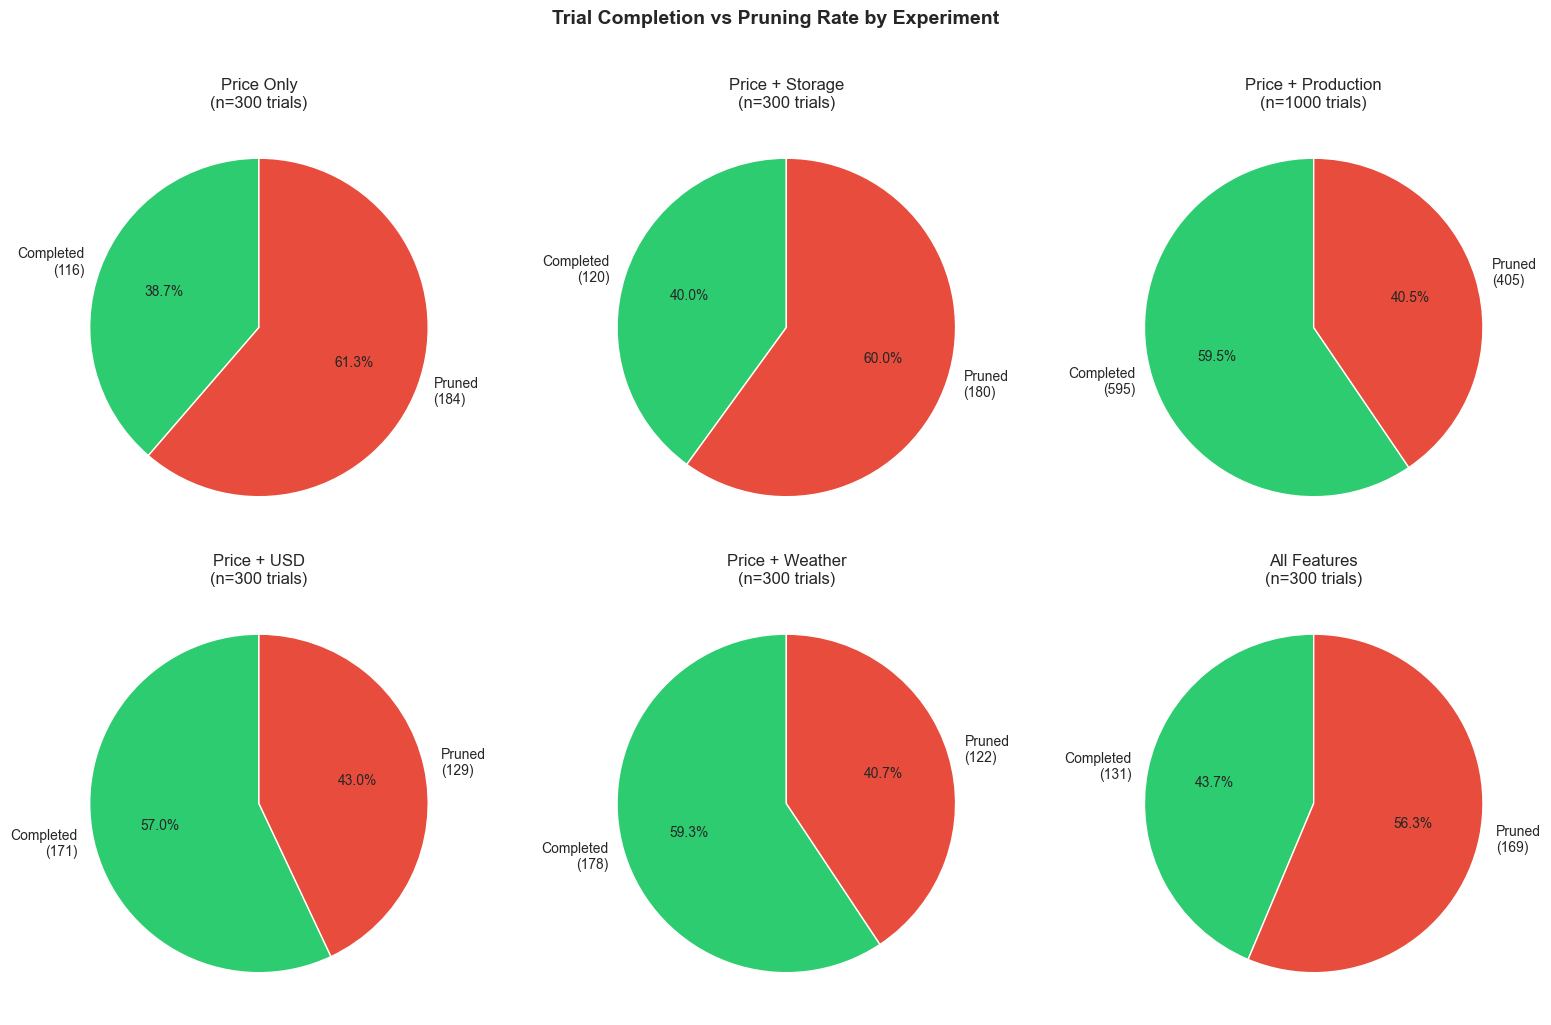


PRUNING EPOCH DISTRIBUTION


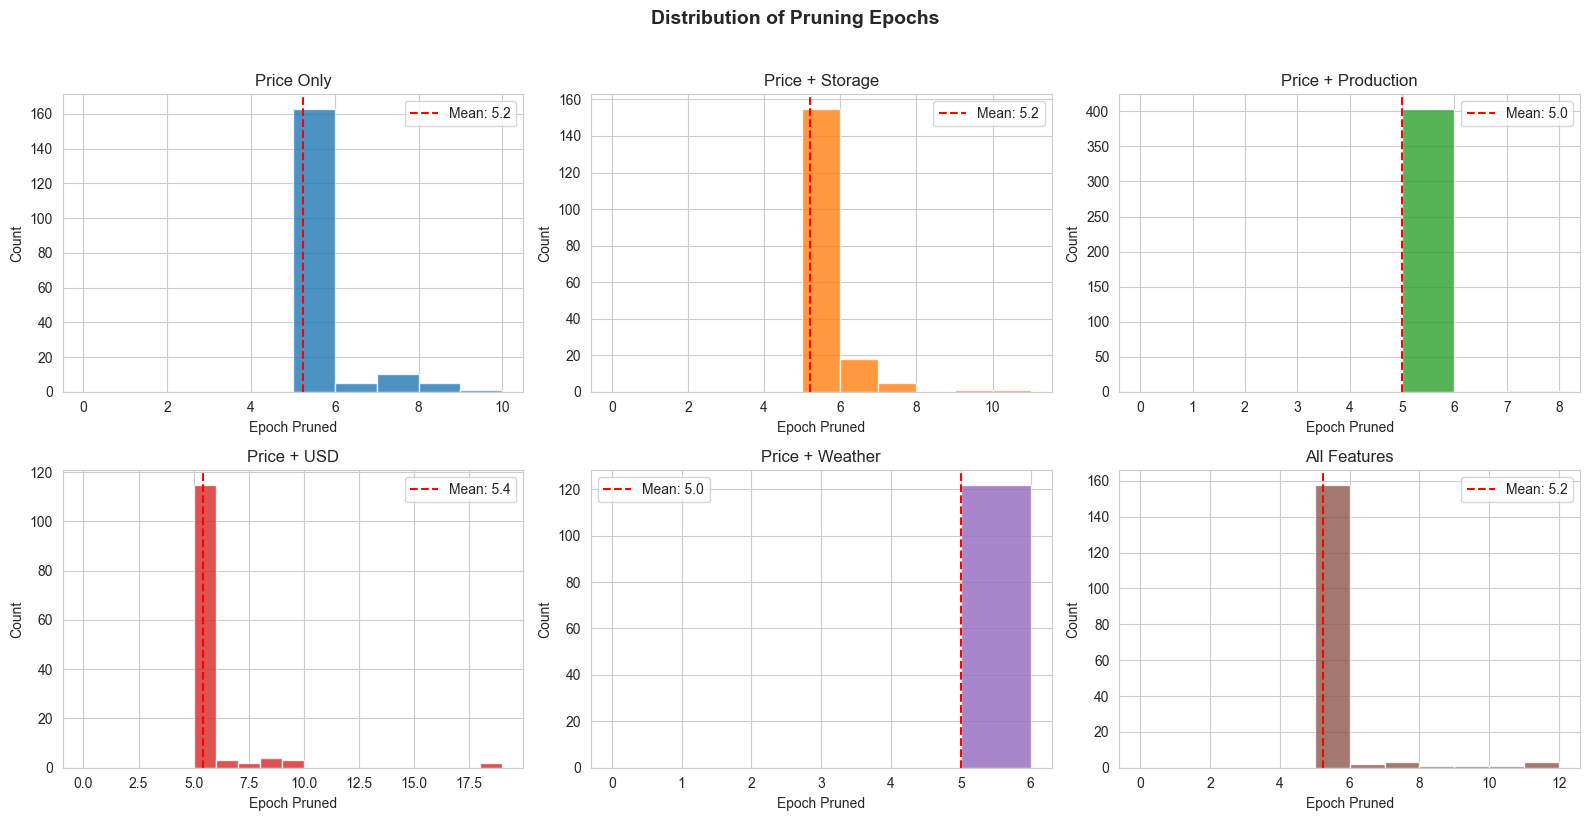

In [4]:
# === Cell 4: Pruning Analysis ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(experiment_data.items()):
    ax = axes[idx]
    
    # Get pruning data
    pruned_df = df[df['state'] == 'PRUNED'].copy()
    completed_df = df[df['state'] == 'COMPLETE'].copy()
    
    # Pruning rate
    pruning_rate = len(pruned_df) / len(df) * 100
    completion_rate = len(completed_df) / len(df) * 100
    
    # Create pie chart
    sizes = [completion_rate, pruning_rate]
    labels = [f'Completed\n({len(completed_df)})', f'Pruned\n({len(pruned_df)})']
    colors = ['#2ecc71', '#e74c3c']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{name}\n(n={len(df)} trials)')

plt.suptitle('Trial Completion vs Pruning Rate by Experiment', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Pruning epoch distribution
print("\n" + "=" * 80)
print("PRUNING EPOCH DISTRIBUTION")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, df) in enumerate(experiment_data.items()):
    ax = axes[idx]
    
    pruned_df = df[df['state'] == 'PRUNED'].copy()
    
    if 'pruned_epoch' in df.columns and len(pruned_df) > 0:
        pruned_epochs = pruned_df['pruned_epoch'].dropna()
        if len(pruned_epochs) > 0:
            ax.hist(pruned_epochs, bins=range(0, int(pruned_epochs.max()) + 2), 
                   color=EXPERIMENT_COLORS.get(name, '#333'), edgecolor='white', alpha=0.8)
            ax.axvline(pruned_epochs.mean(), color='red', linestyle='--', 
                      label=f'Mean: {pruned_epochs.mean():.1f}')
            ax.legend()
    
    ax.set_title(name)
    ax.set_xlabel('Epoch Pruned')
    ax.set_ylabel('Count')

plt.suptitle('Distribution of Pruning Epochs', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Best Model Metrics Comparison

Compare the best models from each experiment across key metrics.

BEST MODEL FROM EACH EXPERIMENT


,Experiment,Trial #,Val Loss,Test MAE,Test RMSE,Test MAPE (%),Directional Acc (%),Lookback,Batch Size,Layers,Dropout,Learning Rate
0,Price Only,225,0.090967,0.207545,0.685441,6.578504,45.406360,45,64,1,0.00,0.002357
1,Price + Storage,214,0.090365,0.209618,0.698195,6.650958,46.113074,45,64,1,0.00,0.002820
2,Price + Production,603,0.098212,0.214337,0.663255,7.222757,47.912886,60,32,1,0.05,0.002812
3,Price + USD,73,0.104384,0.233258,0.717190,7.510782,47.368421,60,32,2,0.05,0.000774
4,Price + Weather,277,0.108346,0.210935,0.697274,6.936520,48.409894,45,32,2,0.00,0.002664
5,All Features,163,0.118339,0.227577,0.718888,7.205964,46.289753,45,32,1,0.00,0.002691


/var/folders/c3/02gx_gf97cgbycm1nzl631_h0000gn/T/ipykernel_23732/3121461295.py:89: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/c3/02gx_gf97cgbycm1nzl631_h0000gn/T/ipykernel_23732/3121461295.py:89: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/adam/Documents/CS310 - 3rd Year Project/Baseline LSTM Model/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/adam/Documents/CS310 - 3rd Year Project/Baseline LSTM Model/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


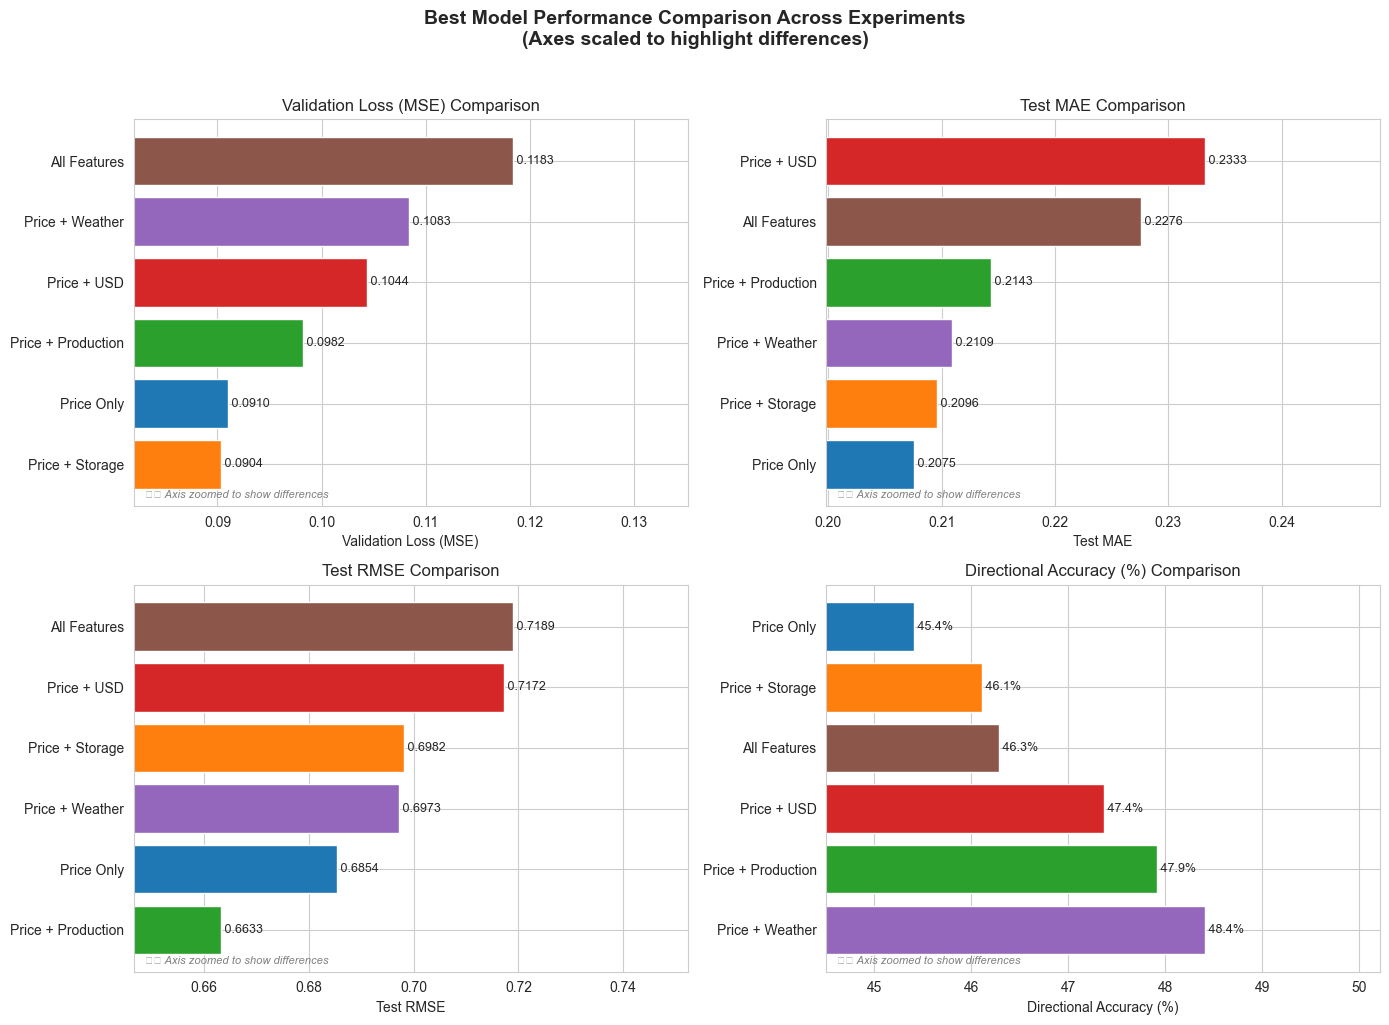


RELATIVE PERFORMANCE (% difference from best)


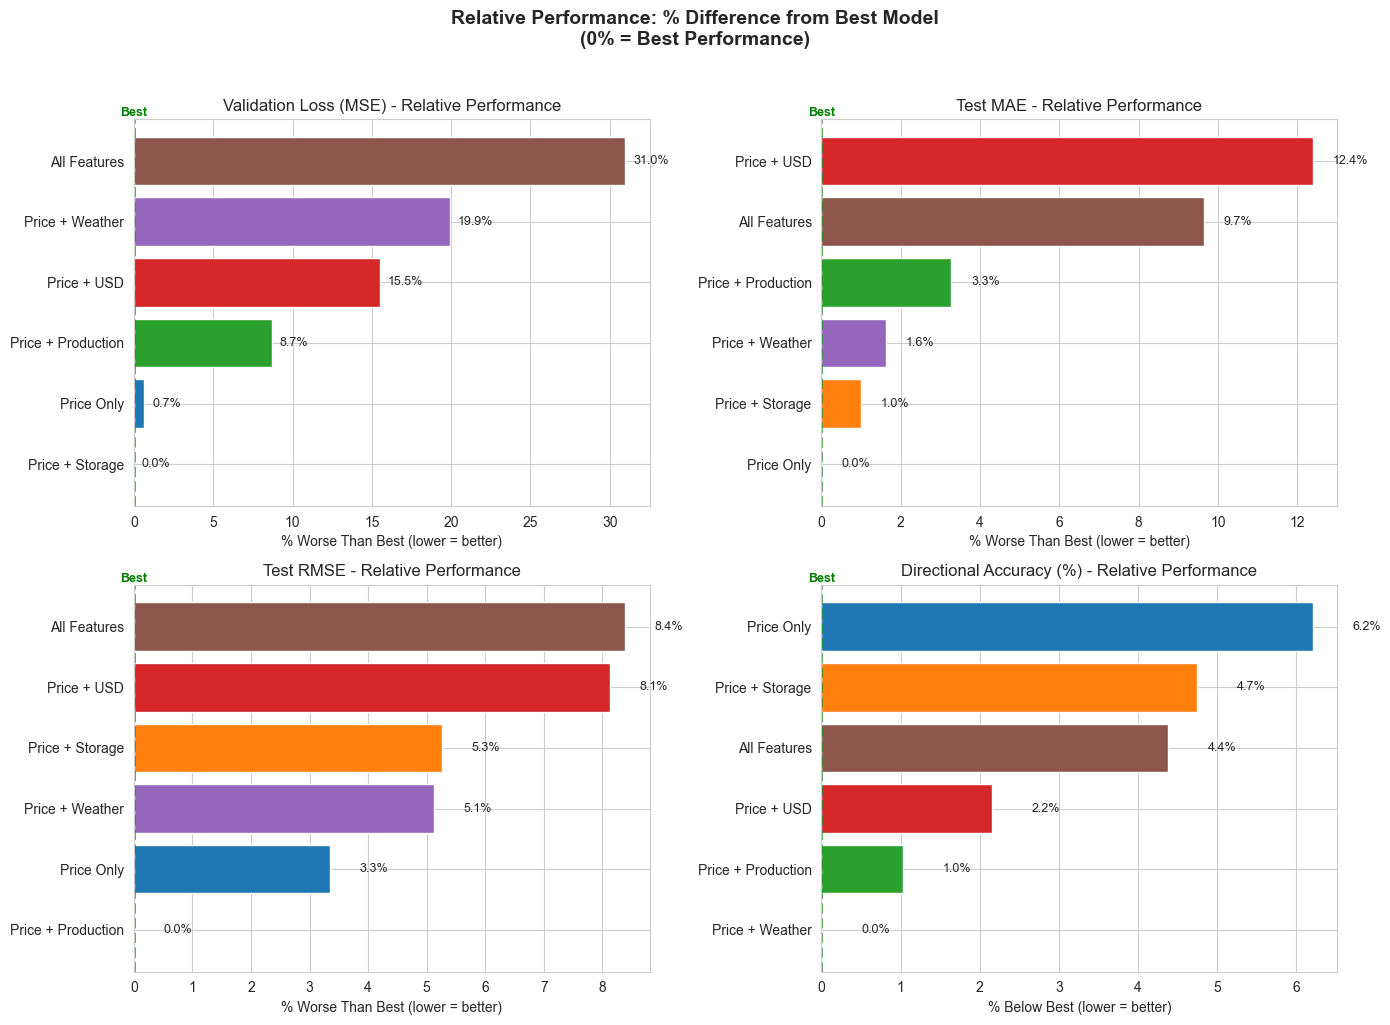

In [5]:
# === Cell 5: Best Model Comparison ===

def get_best_model_metrics(df: pd.DataFrame, name: str) -> dict:
    """Get metrics for the best model (lowest val loss)."""
    completed = df[df['state'] == 'COMPLETE'].copy()
    if len(completed) == 0:
        return None
    
    best_idx = completed['value'].idxmin()
    best = completed.loc[best_idx]
    
    return {
        'Experiment': name,
        'Trial #': best['trial_number'],
        'Val Loss': best['value'],
        'Test MAE': best.get('test_mae'),
        'Test RMSE': best.get('test_rmse'),
        'Test MAPE (%)': best.get('test_mape'),
        'Directional Acc (%)': best.get('test_directional_accuracy'),
        'Lookback': best.get('lookback'),
        'Batch Size': best.get('batch_size'),
        'Layers': best.get('layers'),
        'Dropout': best.get('dropout'),
        'Learning Rate': best.get('lr')
    }

# Collect best models
best_models = []
for name, df in experiment_data.items():
    result = get_best_model_metrics(df, name)
    if result:
        best_models.append(result)

best_df = pd.DataFrame(best_models)

print("=" * 80)
print("BEST MODEL FROM EACH EXPERIMENT")
print("=" * 80)
display(best_df)

# Create comparison bar charts with ZOOMED axes to show differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('Val Loss', 'Validation Loss (MSE)', True),  # lower is better
    ('Test MAE', 'Test MAE', True),
    ('Test RMSE', 'Test RMSE', True),
    ('Directional Acc (%)', 'Directional Accuracy (%)', False)  # higher is better
]

for ax, (col, title, lower_better) in zip(axes.flatten(), metrics):
    data = best_df[['Experiment', col]].dropna()
    if len(data) == 0:
        continue
    
    # Sort appropriately
    data_sorted = data.sort_values(col, ascending=lower_better)
    
    colors = [EXPERIMENT_COLORS.get(exp, '#333') for exp in data_sorted['Experiment']]
    bars = ax.barh(data_sorted['Experiment'], data_sorted[col], color=colors)
    
    ax.set_xlabel(title)
    ax.set_title(f'{title} Comparison')
    
    # Add value labels
    for bar, val in zip(bars, data_sorted[col]):
        ax.text(val, bar.get_y() + bar.get_height()/2, 
               f' {val:.4f}' if col != 'Directional Acc (%)' else f' {val:.1f}%',
               va='center', ha='left', fontsize=9)
    
    # === ZOOM IN on the data range to show differences ===
    data_min = data_sorted[col].min()
    data_max = data_sorted[col].max()
    data_range = data_max - data_min
    
    if data_range > 0:
        # Add padding (20% on each side of the range)
        padding = data_range * 0.3
        # Start axis from slightly below min, not from 0
        ax.set_xlim(max(0, data_min - padding), data_max + padding * 2)  # extra space for labels
    
    # Add a note about the zoomed scale
    ax.annotate('⚠️ Axis zoomed to show differences', 
                xy=(0.02, 0.02), xycoords='axes fraction',
                fontsize=8, color='gray', style='italic')

plt.suptitle('Best Model Performance Comparison Across Experiments\n(Axes scaled to highlight differences)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === ADDITIONAL: Relative Performance Chart (% worse than best) ===
print("\n" + "=" * 80)
print("RELATIVE PERFORMANCE (% difference from best)")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (col, title, lower_better) in zip(axes.flatten(), metrics):
    data = best_df[['Experiment', col]].dropna().copy()
    if len(data) == 0:
        continue
    
    # Calculate relative performance
    if lower_better:
        # For error metrics: % worse than best (lower = better, so best has 0%)
        best_val = data[col].min()
        data['relative'] = ((data[col] - best_val) / best_val) * 100
        ylabel = '% Worse Than Best (lower = better)'
    else:
        # For accuracy: % below best (higher = better)
        best_val = data[col].max()
        data['relative'] = ((best_val - data[col]) / best_val) * 100
        ylabel = '% Below Best (lower = better)'
    
    # Sort by relative performance (best first)
    data_sorted = data.sort_values('relative', ascending=True)
    
    colors = [EXPERIMENT_COLORS.get(exp, '#333') for exp in data_sorted['Experiment']]
    bars = ax.barh(data_sorted['Experiment'], data_sorted['relative'], color=colors)
    
    ax.set_xlabel(ylabel)
    ax.set_title(f'{title} - Relative Performance')
    
    # Add value labels
    for bar, val in zip(bars, data_sorted['relative']):
        label_x = val + 0.5 if val >= 0 else val - 0.5
        ax.text(label_x, bar.get_y() + bar.get_height()/2, 
               f'{val:.1f}%', va='center', ha='left' if val >= 0 else 'right', fontsize=9)
    
    # Add reference line at 0
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.annotate('Best', xy=(0, ax.get_ylim()[1]), ha='center', va='bottom', 
                color='green', fontsize=9, fontweight='bold')

plt.suptitle('Relative Performance: % Difference from Best Model\n(0% = Best Performance)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Hyperparameter Analysis by Experiment

Analyze which hyperparameter values led to best results within each experiment.

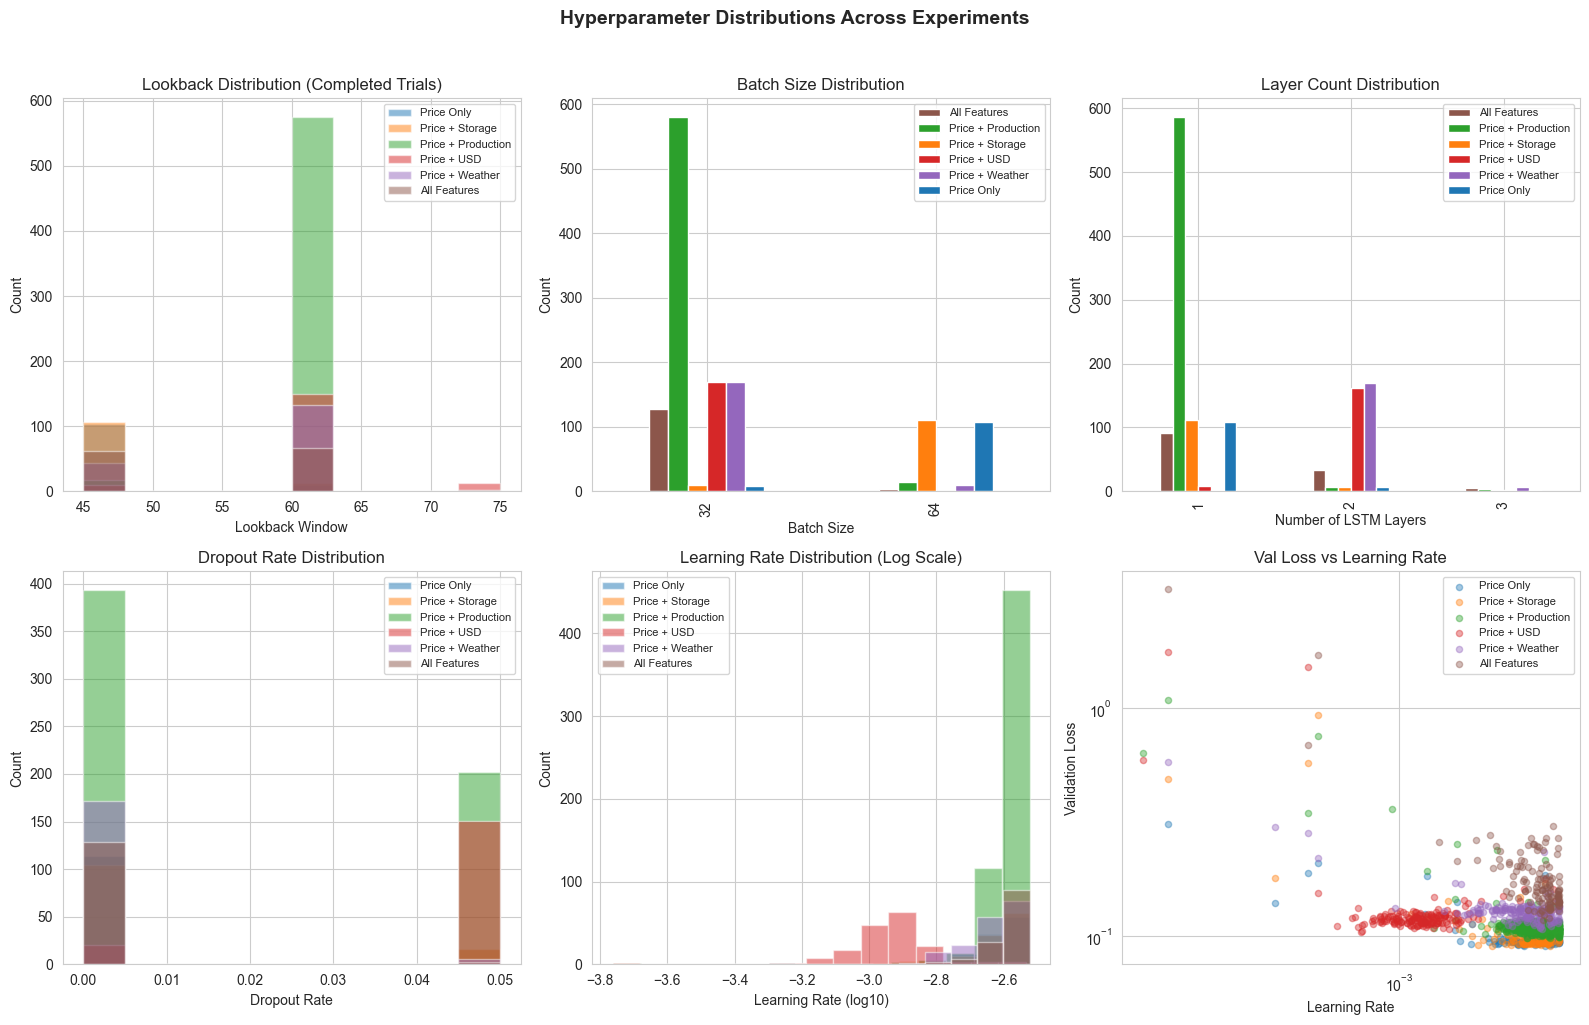

In [6]:
# === Cell 6: Hyperparameter Distribution Analysis ===

# Combine all completed trials
all_completed = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed['experiment'] = name
    all_completed.append(completed)

combined_df = pd.concat(all_completed, ignore_index=True)

# Hyperparameter distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback distribution by experiment
ax = axes[0, 0]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['lookback'].dropna()
    if len(data) > 0:
        ax.hist(data, bins=10, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Lookback Window')
ax.set_ylabel('Count')
ax.set_title('Lookback Distribution (Completed Trials)')
ax.legend(fontsize=8)

# 2. Batch size distribution
ax = axes[0, 1]
batch_sizes = combined_df.groupby(['experiment', 'batch_size']).size().unstack(fill_value=0)
batch_sizes.T.plot(kind='bar', ax=ax, color=[EXPERIMENT_COLORS.get(exp, '#333') for exp in batch_sizes.index])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Count')
ax.set_title('Batch Size Distribution')
ax.legend(fontsize=8)

# 3. Number of layers distribution
ax = axes[0, 2]
layers = combined_df.groupby(['experiment', 'layers']).size().unstack(fill_value=0)
layers.T.plot(kind='bar', ax=ax, color=[EXPERIMENT_COLORS.get(exp, '#333') for exp in layers.index])
ax.set_xlabel('Number of LSTM Layers')
ax.set_ylabel('Count')
ax.set_title('Layer Count Distribution')
ax.legend(fontsize=8)

# 4. Dropout distribution
ax = axes[1, 0]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['dropout'].dropna()
    if len(data) > 0:
        ax.hist(data, bins=10, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Count')
ax.set_title('Dropout Rate Distribution')
ax.legend(fontsize=8)

# 5. Learning rate distribution (log scale)
ax = axes[1, 1]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['lr'].dropna()
    if len(data) > 0:
        ax.hist(np.log10(data), bins=15, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Learning Rate (log10)')
ax.set_ylabel('Count')
ax.set_title('Learning Rate Distribution (Log Scale)')
ax.legend(fontsize=8)

# 6. Val loss vs Learning rate scatter
ax = axes[1, 2]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]
    ax.scatter(data['lr'], data['value'], alpha=0.4, label=name, 
               color=EXPERIMENT_COLORS.get(name, '#333'), s=20)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_title('Val Loss vs Learning Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=8)

plt.suptitle('Hyperparameter Distributions Across Experiments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Hyperparameter Impact Analysis

Analyze how each hyperparameter affects validation loss across experiments.

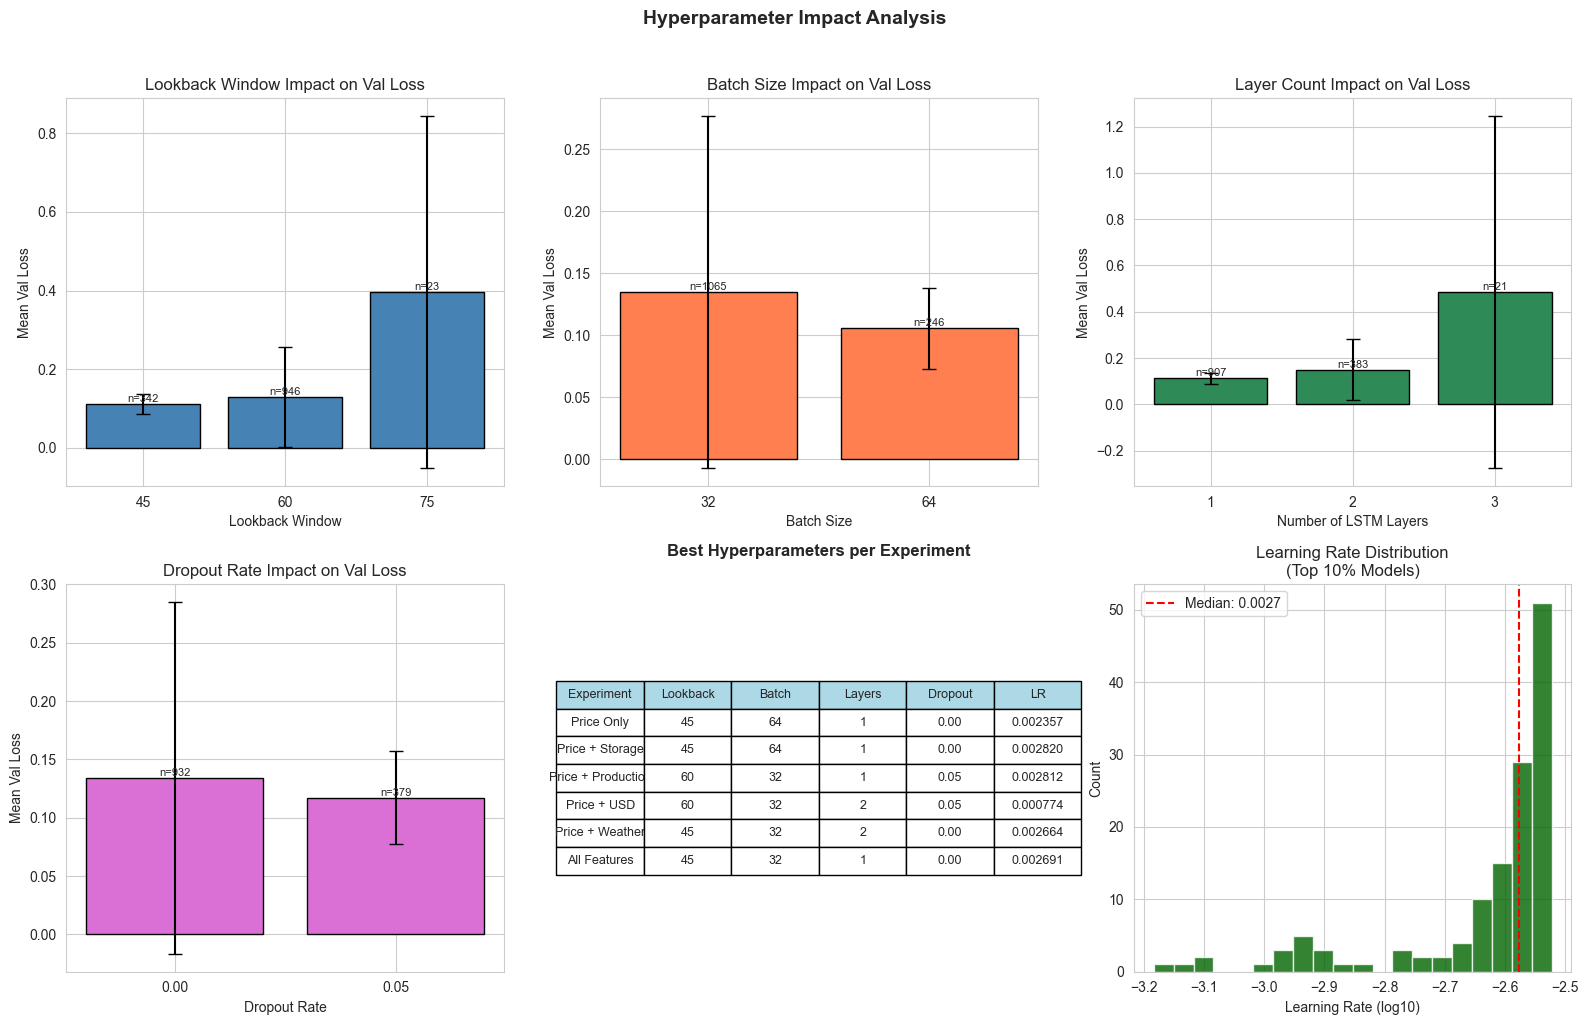

In [7]:
# === Cell 7: Hyperparameter Impact on Performance ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback vs Val Loss boxplot
ax = axes[0, 0]
lookback_groups = combined_df.groupby('lookback')['value'].agg(['mean', 'std', 'count'])
lookback_groups.reset_index(inplace=True)
ax.bar(lookback_groups['lookback'].astype(str), lookback_groups['mean'], 
       yerr=lookback_groups['std'], capsize=5, color='steelblue', edgecolor='black')
ax.set_xlabel('Lookback Window')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Lookback Window Impact on Val Loss')

# Add counts as annotations
for i, row in lookback_groups.iterrows():
    ax.annotate(f'n={int(row["count"])}', xy=(i, row['mean']), 
                ha='center', va='bottom', fontsize=8)

# 2. Batch size vs Val Loss
ax = axes[0, 1]
batch_groups = combined_df.groupby('batch_size')['value'].agg(['mean', 'std', 'count'])
batch_groups.reset_index(inplace=True)
ax.bar(batch_groups['batch_size'].astype(str), batch_groups['mean'],
       yerr=batch_groups['std'], capsize=5, color='coral', edgecolor='black')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Batch Size Impact on Val Loss')

for i, row in batch_groups.iterrows():
    ax.annotate(f'n={int(row["count"])}', xy=(i, row['mean']),
                ha='center', va='bottom', fontsize=8)

# 3. Number of layers vs Val Loss
ax = axes[0, 2]
layer_groups = combined_df.groupby('layers')['value'].agg(['mean', 'std', 'count'])
layer_groups.reset_index(inplace=True)
ax.bar(layer_groups['layers'].astype(str), layer_groups['mean'],
       yerr=layer_groups['std'], capsize=5, color='seagreen', edgecolor='black')
ax.set_xlabel('Number of LSTM Layers')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Layer Count Impact on Val Loss')

for i, row in layer_groups.iterrows():
    ax.annotate(f'n={int(row["count"])}', xy=(i, row['mean']),
                ha='center', va='bottom', fontsize=8)

# 4. Dropout vs Val Loss
ax = axes[1, 0]
dropout_groups = combined_df.groupby('dropout')['value'].agg(['mean', 'std', 'count'])
dropout_groups.reset_index(inplace=True)
ax.bar([f'{d:.2f}' for d in dropout_groups['dropout']], dropout_groups['mean'],
       yerr=dropout_groups['std'], capsize=5, color='orchid', edgecolor='black')
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Dropout Rate Impact on Val Loss')

for i, row in dropout_groups.iterrows():
    ax.annotate(f'n={int(row["count"])}', xy=(i, row['mean']),
                ha='center', va='bottom', fontsize=8)

# 5. Best hyperparameters per experiment table
ax = axes[1, 1]
ax.axis('off')

# Create summary table of best hyperparameters
best_params_data = []
for name in experiment_data.keys():
    exp_data = combined_df[combined_df['experiment'] == name]
    if len(exp_data) > 0:
        best_row = exp_data.loc[exp_data['value'].idxmin()]
        best_params_data.append({
            'Experiment': name,
            'Lookback': int(best_row['lookback']) if pd.notna(best_row['lookback']) else '-',
            'Batch': int(best_row['batch_size']) if pd.notna(best_row['batch_size']) else '-',
            'Layers': int(best_row['layers']) if pd.notna(best_row['layers']) else '-',
            'Dropout': f"{best_row['dropout']:.2f}" if pd.notna(best_row['dropout']) else '-',
            'LR': f"{best_row['lr']:.6f}" if pd.notna(best_row['lr']) else '-'
        })

best_params_df = pd.DataFrame(best_params_data)
table = ax.table(cellText=best_params_df.values, colLabels=best_params_df.columns,
                 cellLoc='center', loc='center', colColours=['lightblue']*len(best_params_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
ax.set_title('Best Hyperparameters per Experiment', fontsize=12, fontweight='bold', pad=20)

# 6. Learning rate ranges that work
ax = axes[1, 2]
# Get top 10% of models by val loss for each experiment
top_lr = []
for name in experiment_data.keys():
    exp_data = combined_df[combined_df['experiment'] == name]
    threshold = exp_data['value'].quantile(0.1)  # top 10%
    top_models = exp_data[exp_data['value'] <= threshold]
    top_lr.extend(top_models['lr'].tolist())

ax.hist(np.log10(top_lr), bins=20, color='darkgreen', edgecolor='white', alpha=0.8)
ax.axvline(np.log10(np.median(top_lr)), color='red', linestyle='--', 
           label=f'Median: {np.median(top_lr):.4f}')
ax.set_xlabel('Learning Rate (log10)')
ax.set_ylabel('Count')
ax.set_title('Learning Rate Distribution\n(Top 10% Models)')
ax.legend()

plt.suptitle('Hyperparameter Impact Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Cross-Experiment Comparison: Optimal Parameter Ranges

Identify which parameter configurations consistently perform well across all experiments.

OPTIMAL HYPERPARAMETER RANGES ACROSS ALL EXPERIMENTS

📊 PARAMETER FREQUENCY IN TOP-10 MODELS PER EXPERIMENT:
------------------------------------------------------------

🔍 LOOKBACK WINDOW:
     45 days:  39 models ( 65.0%)
     60 days:  21 models ( 35.0%)

🔍 BATCH SIZE:
     32     :  40 models ( 66.7%)
     64     :  20 models ( 33.3%)

🔍 NUMBER OF LAYERS:
      1 layer(s):  40 models ( 66.7%)
      2 layer(s):  20 models ( 33.3%)

🔍 DROPOUT RATE:
    0.00     :  41 models ( 68.3%)
    0.05     :  19 models ( 31.7%)

🔍 LEARNING RATE STATISTICS (Top Models):
   Min:    0.000656
   Max:    0.002995
   Mean:   0.002296
   Median: 0.002534
   Std:    0.000641


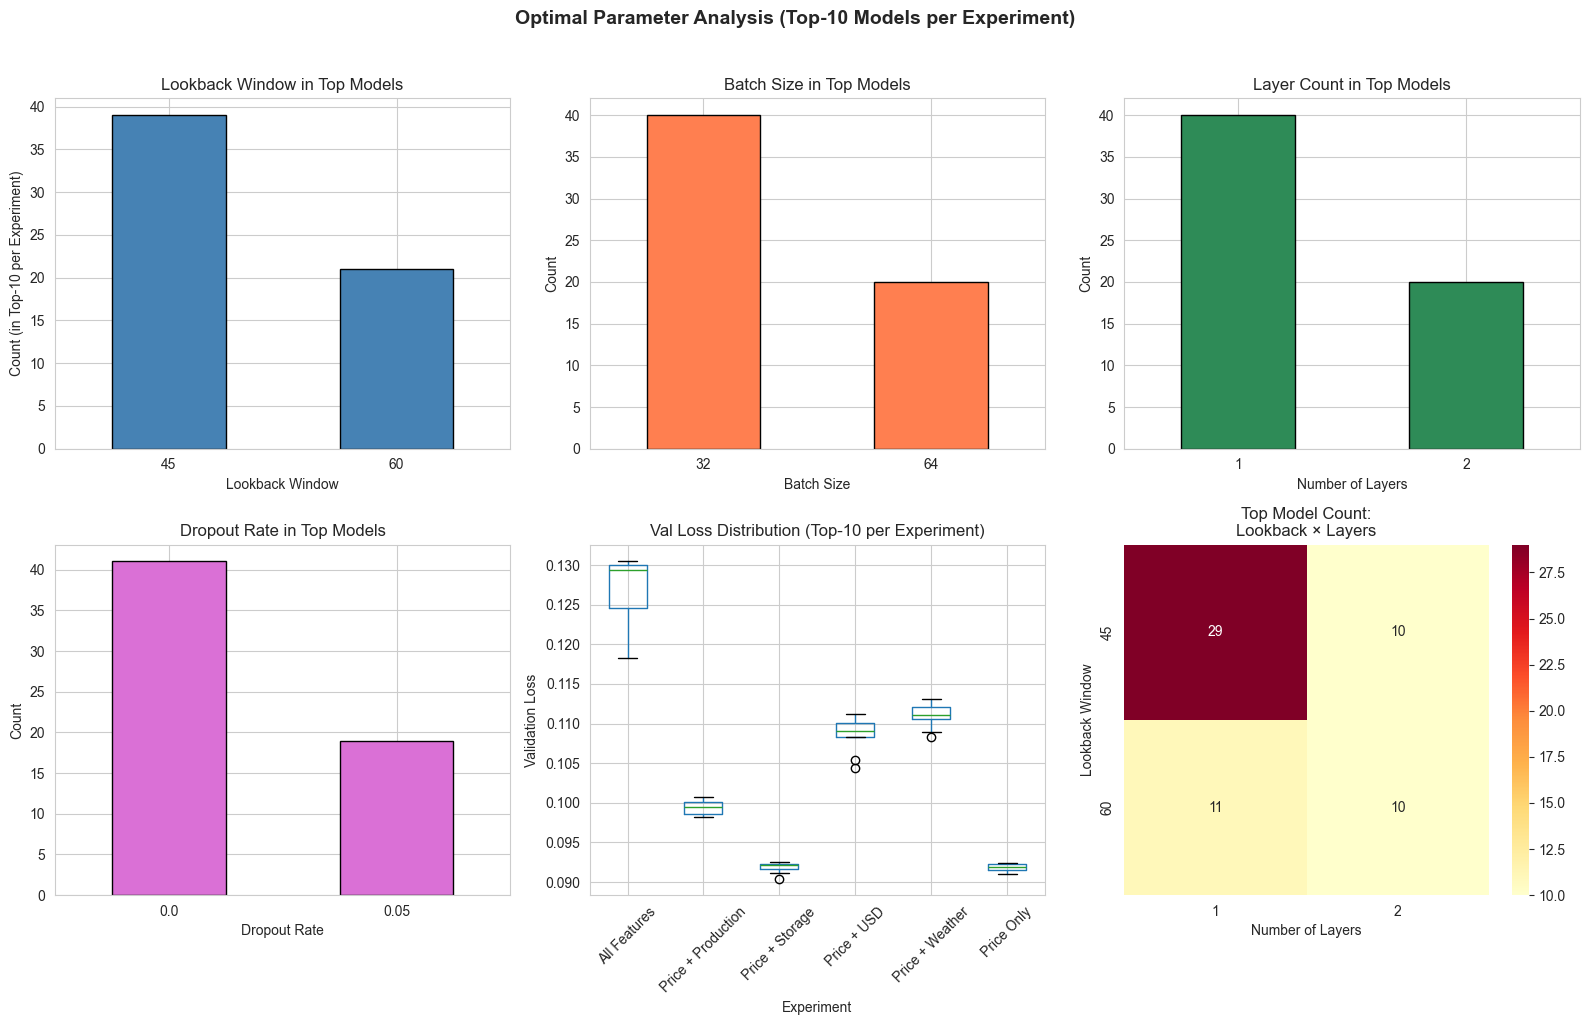

In [8]:
# === Cell 8: Cross-Experiment Optimal Parameter Analysis ===

print("=" * 80)
print("OPTIMAL HYPERPARAMETER RANGES ACROSS ALL EXPERIMENTS")
print("=" * 80)

# Analyze top performers across all experiments
# Get top 10 models from each experiment
top_models_per_exp = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed['experiment'] = name
    top_10 = completed.nsmallest(10, 'value')
    top_models_per_exp.append(top_10)

top_combined = pd.concat(top_models_per_exp, ignore_index=True)

# Parameter frequency analysis
print("\n📊 PARAMETER FREQUENCY IN TOP-10 MODELS PER EXPERIMENT:")
print("-" * 60)

# Lookback
print("\n🔍 LOOKBACK WINDOW:")
lookback_counts = top_combined['lookback'].value_counts()
for lb, count in lookback_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(lb):4d} days: {count:3d} models ({pct:5.1f}%)")

# Batch size
print("\n🔍 BATCH SIZE:")
batch_counts = top_combined['batch_size'].value_counts()
for bs, count in batch_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(bs):4d}     : {count:3d} models ({pct:5.1f}%)")

# Layers
print("\n🔍 NUMBER OF LAYERS:")
layer_counts = top_combined['layers'].value_counts()
for layers, count in layer_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(layers):4d} layer(s): {count:3d} models ({pct:5.1f}%)")

# Dropout
print("\n🔍 DROPOUT RATE:")
dropout_counts = top_combined['dropout'].value_counts()
for dr, count in dropout_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {dr:5.2f}     : {count:3d} models ({pct:5.1f}%)")

# Learning rate ranges
print("\n🔍 LEARNING RATE STATISTICS (Top Models):")
lr_stats = top_combined['lr'].describe()
print(f"   Min:    {lr_stats['min']:.6f}")
print(f"   Max:    {lr_stats['max']:.6f}")
print(f"   Mean:   {lr_stats['mean']:.6f}")
print(f"   Median: {lr_stats['50%']:.6f}")
print(f"   Std:    {lr_stats['std']:.6f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback in top models
ax = axes[0, 0]
lookback_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Lookback Window')
ax.set_ylabel('Count (in Top-10 per Experiment)')
ax.set_title('Lookback Window in Top Models')
ax.tick_params(axis='x', rotation=0)

# 2. Batch size in top models
ax = axes[0, 1]
batch_counts.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Count')
ax.set_title('Batch Size in Top Models')
ax.tick_params(axis='x', rotation=0)

# 3. Layers in top models
ax = axes[0, 2]
layer_counts.plot(kind='bar', ax=ax, color='seagreen', edgecolor='black')
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Count')
ax.set_title('Layer Count in Top Models')
ax.tick_params(axis='x', rotation=0)

# 4. Dropout in top models
ax = axes[1, 0]
dropout_counts.plot(kind='bar', ax=ax, color='orchid', edgecolor='black')
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Count')
ax.set_title('Dropout Rate in Top Models')
ax.tick_params(axis='x', rotation=0)

# 5. Val Loss distribution by experiment (top models only)
ax = axes[1, 1]
top_combined.boxplot(column='value', by='experiment', ax=ax, grid=True)
ax.set_xlabel('Experiment')
ax.set_ylabel('Validation Loss')
ax.set_title('Val Loss Distribution (Top-10 per Experiment)')
plt.suptitle('')  # Remove automatic title
ax.tick_params(axis='x', rotation=45)

# 6. Heatmap of best parameter combinations
ax = axes[1, 2]
# Create cross-tab of lookback vs layers for top models
cross_tab = pd.crosstab(top_combined['lookback'], top_combined['layers'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Lookback Window')
ax.set_title('Top Model Count:\nLookback × Layers')

plt.suptitle('Optimal Parameter Analysis (Top-10 Models per Experiment)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Validation Loss Convergence Analysis

Analyze optimization convergence and trial progression over time.

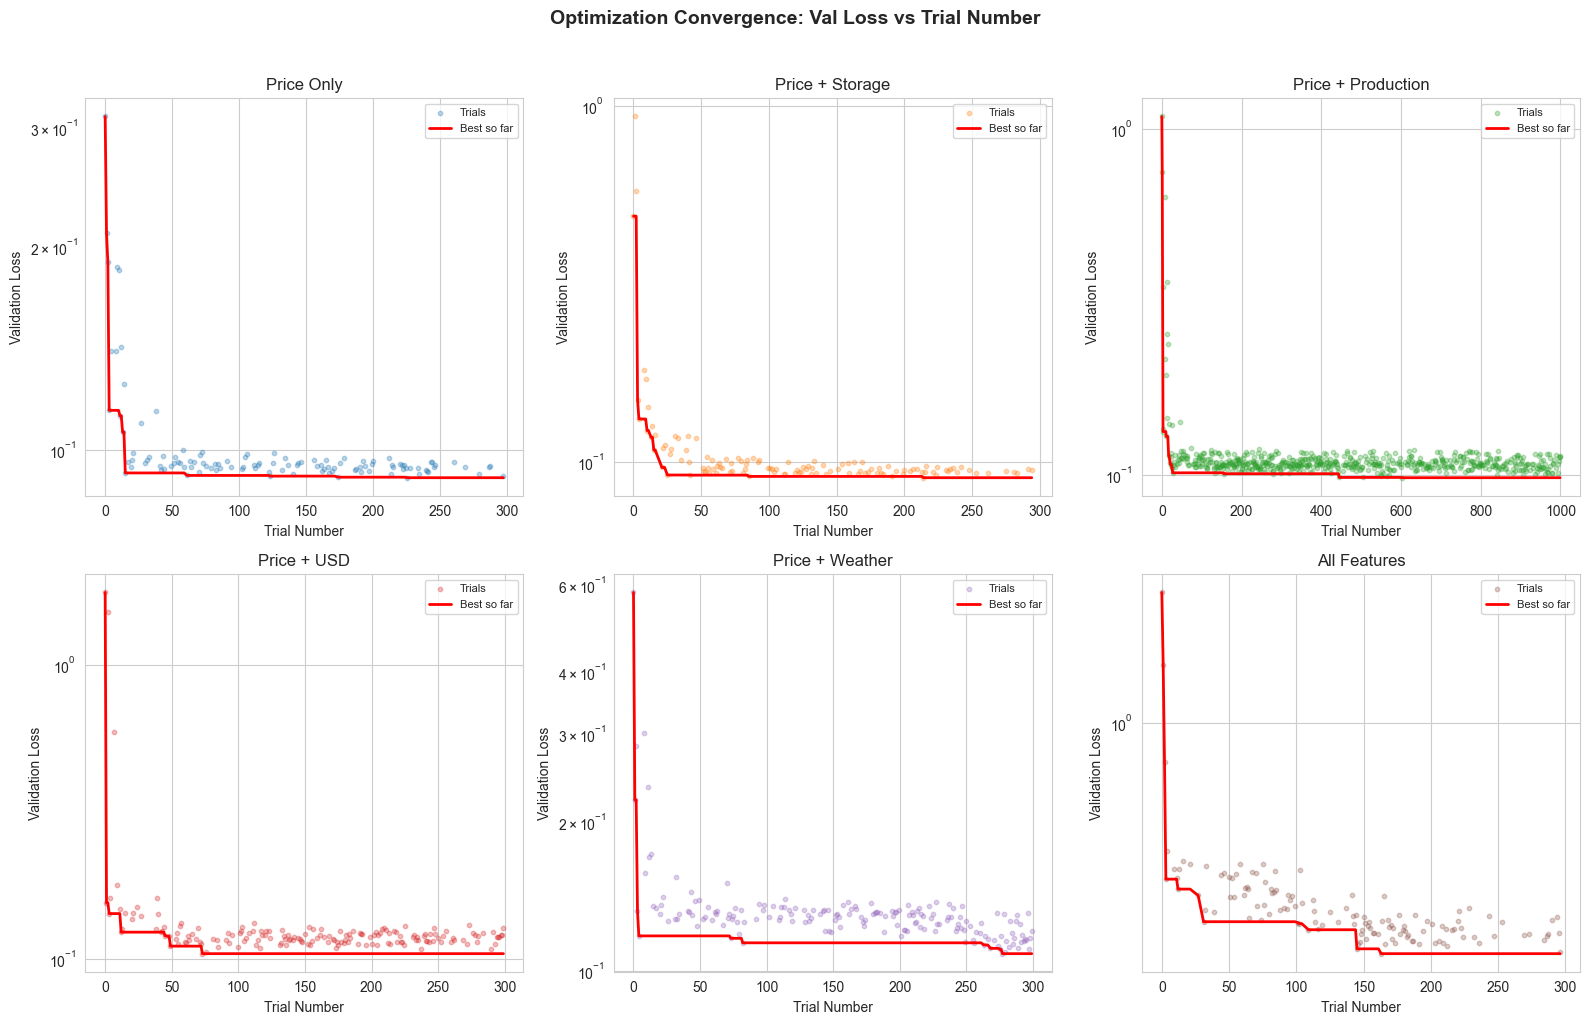


OPTIMIZATION CONVERGENCE SUMMARY


,Experiment,Total Trials,Completed Trials,Final Best Val Loss,Trial Achieving 95% of Best,Efficiency (%)
0,Price Only,300,116,0.090967,15,5.0
1,Price + Storage,300,120,0.090365,25,8.3
2,Price + Production,1000,595,0.098212,27,2.7
3,Price + USD,300,171,0.104384,73,24.3
4,Price + Weather,300,178,0.108346,263,87.7
5,All Features,300,131,0.118339,145,48.3


In [9]:
# === Cell 9: Optimization Convergence Analysis ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(experiment_data.items()):
    ax = axes[idx]
    
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed = completed.sort_values('trial_number')
    
    if len(completed) == 0:
        continue
    
    # Calculate cumulative best
    completed['cumulative_best'] = completed['value'].cummin()
    
    # Plot individual trials
    ax.scatter(completed['trial_number'], completed['value'], 
               alpha=0.3, s=10, c=EXPERIMENT_COLORS.get(name, '#333'), label='Trials')
    
    # Plot cumulative best
    ax.plot(completed['trial_number'], completed['cumulative_best'], 
            color='red', linewidth=2, label='Best so far')
    
    ax.set_xlabel('Trial Number')
    ax.set_ylabel('Validation Loss')
    ax.set_title(f'{name}')
    ax.legend(fontsize=8)
    ax.set_yscale('log')

plt.suptitle('Optimization Convergence: Val Loss vs Trial Number', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary of convergence
print("\n" + "=" * 80)
print("OPTIMIZATION CONVERGENCE SUMMARY")
print("=" * 80)

convergence_data = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed = completed.sort_values('trial_number')
    
    if len(completed) == 0:
        continue
    
    # Find trial where we got within 5% of best
    final_best = completed['value'].min()
    threshold = final_best * 1.05
    
    completed['cumulative_best'] = completed['value'].cummin()
    close_trials = completed[completed['cumulative_best'] <= threshold]
    
    if len(close_trials) > 0:
        first_good_trial = close_trials['trial_number'].iloc[0]
    else:
        first_good_trial = None
    
    convergence_data.append({
        'Experiment': name,
        'Total Trials': len(df),
        'Completed Trials': len(completed),
        'Final Best Val Loss': f"{final_best:.6f}",
        'Trial Achieving 95% of Best': first_good_trial,
        'Efficiency (%)': round(first_good_trial / len(df) * 100, 1) if first_good_trial else None
    })

convergence_df = pd.DataFrame(convergence_data)
display(convergence_df)

## 9. Final Summary & Recommendations

Key findings and recommended configurations based on all experiments.

In [10]:
# === Cell 10: Final Summary & Recommendations ===

print("=" * 80)
print("                    LSTM HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

# Overall best model
all_best = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    if len(completed) > 0:
        best_idx = completed['value'].idxmin()
        best = completed.loc[best_idx].copy()
        best['experiment'] = name
        all_best.append(best)

all_best_df = pd.DataFrame(all_best)
overall_best_idx = all_best_df['value'].idxmin()
overall_best = all_best_df.loc[overall_best_idx]

print(f"\n🏆 OVERALL BEST MODEL:")
print(f"   Experiment: {overall_best['experiment']}")
print(f"   Trial #: {int(overall_best['trial_number'])}")
print(f"   Val Loss: {overall_best['value']:.6f}")
if 'test_mae' in overall_best and pd.notna(overall_best['test_mae']):
    print(f"   Test MAE: {overall_best['test_mae']:.4f}")
if 'test_rmse' in overall_best and pd.notna(overall_best['test_rmse']):
    print(f"   Test RMSE: {overall_best['test_rmse']:.4f}")

print("\n📊 KEY FINDINGS:")
print("-" * 60)

# Best lookback
best_lookback = top_combined.groupby('lookback')['value'].mean().idxmin()
print(f"\n1. OPTIMAL LOOKBACK WINDOW: {int(best_lookback)} days")
print(f"   - Most frequent in top models: {int(lookback_counts.idxmax())} days")

# Best layers
best_layers = top_combined.groupby('layers')['value'].mean().idxmin()
print(f"\n2. OPTIMAL LAYER COUNT: {int(best_layers)} layer(s)")
print(f"   - Single-layer LSTMs dominate top models")

# Best batch size
best_batch = top_combined.groupby('batch_size')['value'].mean().idxmin()
print(f"\n3. OPTIMAL BATCH SIZE: {int(best_batch)}")
print(f"   - Most frequent in top models: {int(batch_counts.idxmax())}")

# Dropout insights
no_dropout_count = len(top_combined[top_combined['dropout'] == 0.0])
with_dropout_count = len(top_combined[top_combined['dropout'] > 0.0])
print(f"\n4. DROPOUT ANALYSIS:")
print(f"   - No dropout (0.0): {no_dropout_count} models ({no_dropout_count/len(top_combined)*100:.1f}%)")
print(f"   - With dropout (>0): {with_dropout_count} models ({with_dropout_count/len(top_combined)*100:.1f}%)")

# Learning rate
lr_median = top_combined['lr'].median()
lr_range = (top_combined['lr'].quantile(0.25), top_combined['lr'].quantile(0.75))
print(f"\n5. OPTIMAL LEARNING RATE RANGE:")
print(f"   - Median: {lr_median:.6f}")
print(f"   - IQR: [{lr_range[0]:.6f}, {lr_range[1]:.6f}]")

# Pruning efficiency
total_trials = sum(len(df) for df in experiment_data.values())
total_pruned = sum(len(df[df['state'] == 'PRUNED']) for df in experiment_data.values())
print(f"\n6. PRUNING EFFICIENCY:")
print(f"   - Total trials: {total_trials}")
print(f"   - Pruned trials: {total_pruned} ({total_pruned/total_trials*100:.1f}%)")
print(f"   - Computational savings: ~{total_pruned/total_trials*100:.0f}% of full training")

# Feature importance ranking (by best val loss)
print("\n7. FEATURE SET RANKING (by best val loss):")
feature_ranking = all_best_df.sort_values('value')[['experiment', 'value']].reset_index(drop=True)
for i, row in feature_ranking.iterrows():
    print(f"   {i+1}. {row['experiment']}: {row['value']:.6f}")

print("\n" + "=" * 80)
print("                         RECOMMENDED CONFIGURATION")
print("=" * 80)
print(f"""
Based on the analysis of {total_trials} trials across {len(experiment_data)} experiments:

┌─────────────────────────────────────────────────────────────┐
│  HYPERPARAMETER          │  RECOMMENDED VALUE              │
├─────────────────────────────────────────────────────────────┤
│  Lookback Window         │  {int(best_lookback)} days (45-75 range)          │
│  LSTM Layers             │  {int(best_layers)} layer (simpler is better)      │
│  Batch Size              │  {int(best_batch)} (32-64 both work well)        │
│  Dropout                 │  0.0 - 0.05 (minimal dropout)   │
│  Learning Rate           │  {lr_median:.4f} ({lr_range[0]:.4f}-{lr_range[1]:.4f}) │
│  Early Stopping          │  Patience 10, restore best      │
└─────────────────────────────────────────────────────────────┘
""")

# Save summary to CSV
summary_output = SAVED_RESULTS_DIR / "analysis_summary.csv"
summary_df.to_csv(summary_output, index=False)
print(f"\n✅ Summary saved to: {summary_output}")

                    LSTM HYPERPARAMETER TUNING SUMMARY

🏆 OVERALL BEST MODEL:
   Experiment: Price + Storage
   Trial #: 214
   Val Loss: 0.090365
   Test MAE: 0.2096
   Test RMSE: 0.6982

📊 KEY FINDINGS:
------------------------------------------------------------

1. OPTIMAL LOOKBACK WINDOW: 45 days
   - Most frequent in top models: 45 days

2. OPTIMAL LAYER COUNT: 1 layer(s)
   - Single-layer LSTMs dominate top models

3. OPTIMAL BATCH SIZE: 64
   - Most frequent in top models: 32

4. DROPOUT ANALYSIS:
   - No dropout (0.0): 41 models (68.3%)
   - With dropout (>0): 19 models (31.7%)

5. OPTIMAL LEARNING RATE RANGE:
   - Median: 0.002534
   - IQR: [0.002110, 0.002742]

6. PRUNING EFFICIENCY:
   - Total trials: 2500
   - Pruned trials: 1189 (47.6%)
   - Computational savings: ~48% of full training

7. FEATURE SET RANKING (by best val loss):
   1. Price + Storage: 0.090365
   2. Price Only: 0.090967
   3. Price + Production: 0.098212
   4. Price + USD: 0.104384
   5. Price + Weather: 

## 10. Load Best Model Metadata (Top-10 Per Experiment)

Load the detailed metadata from saved top models for deeper analysis.

In [11]:
# === Cell 11: Load Top Model Metadata from JSON Files ===

def load_top_model_metadata(experiment_dir: Path) -> List[dict]:
    """Load metadata.json from top_models subdirectories."""
    top_models_dir = experiment_dir / "top_models"
    if not top_models_dir.exists():
        return []
    
    models = []
    for rank_dir in sorted(top_models_dir.iterdir()):
        if rank_dir.is_dir() and rank_dir.name.startswith('rank_'):
            meta_file = rank_dir / "metadata.json"
            if meta_file.exists():
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                    meta['rank_dir'] = str(rank_dir)
                    models.append(meta)
    return models

# Load all top model metadata
all_top_models = {}
for name, folder in EXPERIMENTS.items():
    exp_path = SAVED_RESULTS_DIR / folder
    models = load_top_model_metadata(exp_path)
    if models:
        all_top_models[name] = models
        print(f"✅ Loaded {len(models)} top models for {name}")

# Extract detailed metrics from metadata
detailed_metrics = []
for exp_name, models in all_top_models.items():
    for model in models:
        hp = model.get('hyperparameters', {})
        metrics = model.get('metrics', {})
        test_metrics = metrics.get('test', {})
        val_metrics = metrics.get('val', {})
        
        detailed_metrics.append({
            'Experiment': exp_name,
            'Run Name': model.get('run_name', ''),
            'Lookback': hp.get('lookback'),
            'Batch Size': hp.get('batch_size'),
            'Layers': hp.get('layers'),
            'LSTM Units': str(hp.get('lstm_units', [])),
            'Dropout': hp.get('dropout'),
            'Learning Rate': hp.get('lr'),
            'Val Loss': val_metrics.get('loss'),
            'Test MAE': test_metrics.get('MAE'),
            'Test RMSE': test_metrics.get('RMSE'),
            'Test MAPE': test_metrics.get('MAPE'),
            'Test DA': test_metrics.get('Directional_Accuracy')
        })

detailed_df = pd.DataFrame(detailed_metrics)

if len(detailed_df) > 0:
    print("\n" + "=" * 80)
    print("DETAILED TOP MODEL METRICS (from saved metadata.json)")
    print("=" * 80)
    display(detailed_df.head(20))

✅ Loaded 10 top models for Price Only
✅ Loaded 10 top models for Price + Storage
✅ Loaded 10 top models for Price + Production
✅ Loaded 10 top models for Price + USD
✅ Loaded 10 top models for Price + Weather
✅ Loaded 10 top models for All Features

DETAILED TOP MODEL METRICS (from saved metadata.json)


,Experiment,Run Name,Lookback,Batch Size,Layers,LSTM Units,Dropout,Learning Rate,Val Loss,Test MAE,Test RMSE,Test MAPE,Test DA
0,Price Only,Price Only | trial 0225 | rank 01,45,64,1,[64],0.00,0.002357,0.090967,0.192619,0.655877,6.123414,44.522968
1,Price Only,Price Only | trial 0174 | rank 02,45,64,1,[64],0.00,0.002729,0.091124,0.201835,0.677038,6.465937,46.643110
2,Price Only,Price Only | trial 0123 | rank 03,45,64,1,[64],0.00,0.002348,0.091464,0.207178,0.683873,6.712882,47.703180
3,Price Only,Price Only | trial 0297 | rank 04,45,64,1,[64],0.00,0.002810,0.091466,0.204612,0.675864,6.645641,46.289753
4,Price Only,Price Only | trial 0061 | rank 05,45,64,1,[64],0.00,0.002259,0.091672,0.200354,0.676796,6.399586,46.466431
5,Price Only,Price Only | trial 0279 | rank 06,45,64,1,[64],0.00,0.002547,0.092133,0.208357,0.706908,6.739558,47.703180
6,Price Only,Price Only | trial 0213 | rank 07,45,64,1,[64],0.00,0.002915,0.092232,0.200184,0.681491,6.414417,45.759717
7,Price Only,Price Only | trial 0234 | rank 08,45,64,1,[64],0.00,0.001939,0.092235,0.206977,0.699344,6.576523,45.936396
8,Price Only,Price Only | trial 0140 | rank 09,45,64,1,[64],0.00,0.001978,0.092253,0.201485,0.678518,6.509655,45.759717
9,Price Only,Price Only | trial 0167 | rank 10,45,64,1,[64],0.00,0.002269,0.092385,0.202373,0.680083,6.576399,46.466431


## 11. Radar Chart: Multi-Metric Comparison

Visual comparison of all metrics across experiments using a radar/spider chart.

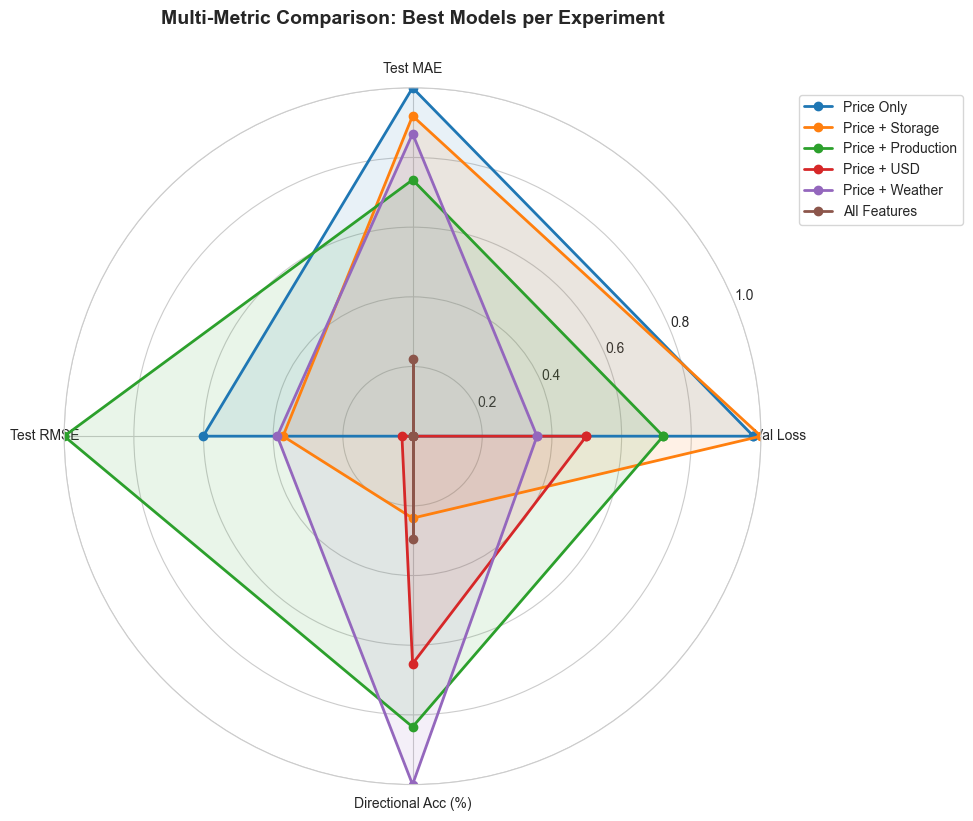

In [12]:
# === Cell 12: Radar Chart Multi-Metric Comparison ===

from math import pi

def create_radar_chart(df, metrics, title="Model Comparison"):
    """Create a radar chart comparing experiments across multiple metrics."""
    
    # Normalize metrics (invert those where lower is better)
    radar_data = df[['Experiment'] + metrics].dropna().copy()
    
    if len(radar_data) == 0:
        print("No data available for radar chart")
        return
    
    # Normalize each metric to 0-1 scale
    for metric in metrics:
        col = radar_data[metric]
        min_val, max_val = col.min(), col.max()
        if max_val > min_val:
            # For error metrics, invert so higher = better
            if metric in ['Val Loss', 'Test MAE', 'Test RMSE', 'Test MAPE (%)']:
                radar_data[metric + '_norm'] = 1 - (col - min_val) / (max_val - min_val)
            else:
                radar_data[metric + '_norm'] = (col - min_val) / (max_val - min_val)
        else:
            radar_data[metric + '_norm'] = 0.5
    
    # Set up radar chart
    norm_metrics = [m + '_norm' for m in metrics]
    num_vars = len(metrics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for idx, row in radar_data.iterrows():
        values = [row[m] for m in norm_metrics]
        values += values[:1]
        
        color = EXPERIMENT_COLORS.get(row['Experiment'], '#333')
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Experiment'], color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=10)
    ax.set_ylim(0, 1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title(title, size=14, fontweight='bold', y=1.08)
    plt.tight_layout()
    plt.show()

# Create radar chart if we have best model data
if len(best_df) > 0:
    radar_metrics = ['Val Loss', 'Test MAE', 'Test RMSE', 'Directional Acc (%)']
    available_metrics = [m for m in radar_metrics if m in best_df.columns and best_df[m].notna().any()]
    
    if len(available_metrics) >= 3:
        create_radar_chart(best_df, available_metrics, 
                          "Multi-Metric Comparison: Best Models per Experiment")
    else:
        print("Not enough metrics available for radar chart")

## 12. Correlation Analysis: Hyperparameters vs Performance

Analyze correlations between hyperparameters and model performance.

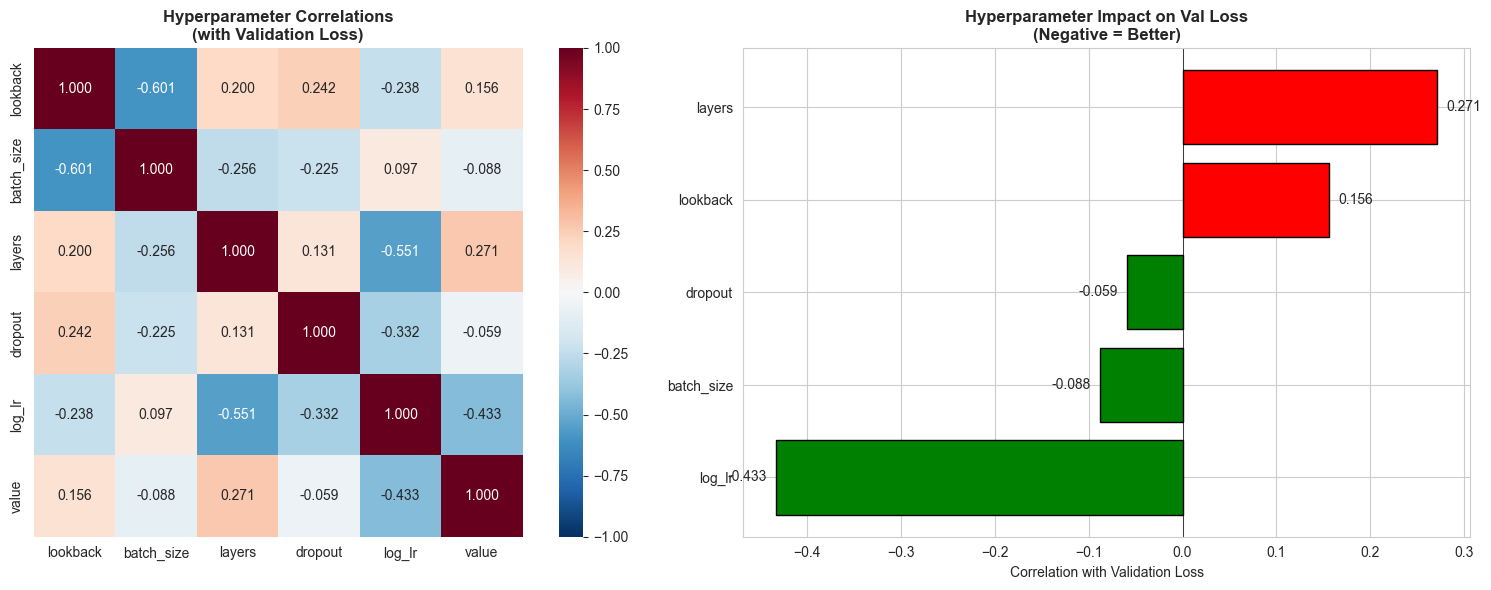


CORRELATION INTERPRETATION

📈 CORRELATION WITH VALIDATION LOSS:
   Negative correlation = Lower val loss (better performance)
   Positive correlation = Higher val loss (worse performance)

   log_lr      : -0.433 → BENEFICIAL
   batch_size  : -0.088 → BENEFICIAL
   dropout     : -0.059 → BENEFICIAL
   lookback    : +0.156 → DETRIMENTAL
   layers      : +0.271 → DETRIMENTAL


In [13]:
# === Cell 13: Correlation Analysis ===

# Prepare data for correlation
corr_cols = ['lookback', 'batch_size', 'layers', 'dropout', 'lr', 'value']
corr_data = combined_df[corr_cols].dropna()

# Add log learning rate for better correlation
corr_data['log_lr'] = np.log10(corr_data['lr'])

# Compute correlation matrix
corr_matrix = corr_data[['lookback', 'batch_size', 'layers', 'dropout', 'log_lr', 'value']].corr()

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Full correlation heatmap
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1)
ax.set_title('Hyperparameter Correlations\n(with Validation Loss)', fontsize=12, fontweight='bold')

# 2. Bar chart of correlations with val loss
ax = axes[1]
val_corr = corr_matrix['value'].drop('value').sort_values()
colors = ['green' if c < 0 else 'red' for c in val_corr]
ax.barh(val_corr.index, val_corr.values, color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Correlation with Validation Loss')
ax.set_title('Hyperparameter Impact on Val Loss\n(Negative = Better)', fontsize=12, fontweight='bold')

# Add value labels
for i, (idx, val) in enumerate(val_corr.items()):
    ax.text(val + 0.01 if val >= 0 else val - 0.01, i, f'{val:.3f}', 
            va='center', ha='left' if val >= 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "=" * 80)
print("CORRELATION INTERPRETATION")
print("=" * 80)
print("""
📈 CORRELATION WITH VALIDATION LOSS:
   Negative correlation = Lower val loss (better performance)
   Positive correlation = Higher val loss (worse performance)
""")

for param, corr in val_corr.items():
    direction = "BENEFICIAL" if corr < 0 else "DETRIMENTAL" if corr > 0.1 else "NEUTRAL"
    print(f"   {param:12}: {corr:+.3f} → {direction}")

## 13. Export Summary Tables

Export all summary data to CSV files for use in thesis/reports.

In [14]:
# === Cell 14: Export Summary Tables ===

import datetime

# Create output directory
OUTPUT_DIR = SAVED_RESULTS_DIR / "analysis_output"
OUTPUT_DIR.mkdir(exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Export experiment summary
summary_file = OUTPUT_DIR / f"experiment_summary_{timestamp}.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✅ Saved: {summary_file}")

# 2. Export best model comparison
if len(best_df) > 0:
    best_file = OUTPUT_DIR / f"best_models_comparison_{timestamp}.csv"
    best_df.to_csv(best_file, index=False)
    print(f"✅ Saved: {best_file}")

# 3. Export detailed top model metrics
if len(detailed_df) > 0:
    detailed_file = OUTPUT_DIR / f"detailed_top_models_{timestamp}.csv"
    detailed_df.to_csv(detailed_file, index=False)
    print(f"✅ Saved: {detailed_file}")

# 4. Export optimal parameter summary
optimal_params = {
    'Parameter': ['Lookback', 'Batch Size', 'Layers', 'Dropout', 'Learning Rate (median)', 'Learning Rate (IQR low)', 'Learning Rate (IQR high)'],
    'Optimal Value': [
        int(best_lookback) if 'best_lookback' in dir() else '-',
        int(best_batch) if 'best_batch' in dir() else '-',
        int(best_layers) if 'best_layers' in dir() else '-',
        '0.0 - 0.05',
        f"{lr_median:.6f}" if 'lr_median' in dir() else '-',
        f"{lr_range[0]:.6f}" if 'lr_range' in dir() else '-',
        f"{lr_range[1]:.6f}" if 'lr_range' in dir() else '-'
    ],
    'Notes': [
        'Most frequent in top models',
        'Both 32 and 64 work well',
        'Single layer preferred',
        'Minimal regularization needed',
        'Center of optimal range',
        '25th percentile',
        '75th percentile'
    ]
}
optimal_df = pd.DataFrame(optimal_params)
optimal_file = OUTPUT_DIR / f"optimal_parameters_{timestamp}.csv"
optimal_df.to_csv(optimal_file, index=False)
print(f"✅ Saved: {optimal_file}")

# 5. Export pruning summary
pruning_data = []
for name, df in experiment_data.items():
    pruned = df[df['state'] == 'PRUNED']
    completed = df[df['state'] == 'COMPLETE']
    
    pruned_epochs = pruned['pruned_epoch'].dropna() if 'pruned_epoch' in df.columns else pd.Series([])
    
    pruning_data.append({
        'Experiment': name,
        'Total Trials': len(df),
        'Completed': len(completed),
        'Pruned': len(pruned),
        'Pruning Rate (%)': round(len(pruned) / len(df) * 100, 1),
        'Mean Pruned Epoch': round(pruned_epochs.mean(), 1) if len(pruned_epochs) > 0 else None,
        'Median Pruned Epoch': round(pruned_epochs.median(), 1) if len(pruned_epochs) > 0 else None
    })

pruning_df = pd.DataFrame(pruning_data)
pruning_file = OUTPUT_DIR / f"pruning_summary_{timestamp}.csv"
pruning_df.to_csv(pruning_file, index=False)
print(f"✅ Saved: {pruning_file}")

print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
print("\nFiles exported:")
for f in OUTPUT_DIR.glob(f"*{timestamp}*"):
    print(f"   - {f.name}")

✅ Saved: saved_results/analysis_output/experiment_summary_20260114_042526.csv
✅ Saved: saved_results/analysis_output/best_models_comparison_20260114_042526.csv
✅ Saved: saved_results/analysis_output/detailed_top_models_20260114_042526.csv
✅ Saved: saved_results/analysis_output/optimal_parameters_20260114_042526.csv
✅ Saved: saved_results/analysis_output/pruning_summary_20260114_042526.csv

📁 All outputs saved to: saved_results/analysis_output

Files exported:
   - detailed_top_models_20260114_042526.csv
   - best_models_comparison_20260114_042526.csv
   - optimal_parameters_20260114_042526.csv
   - pruning_summary_20260114_042526.csv
   - experiment_summary_20260114_042526.csv
